<a href="https://colab.research.google.com/github/Gressling/cheminf-EDU/blob/main/machineLearning/nanoparticle_data_synthesis_optimization/nanoparticle_CNN_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimisation of nanoparticle synthesis: Python version

In the next steps, we switch from the R-based analysis to a Python implementation. Based on the results of the GAM analysis, we prepare the data for training a Convolutional Neural Network (CNN). The CNN can capture more complex patterns and interactions between the variables, which may be necessary for particle size prediction.

## Data preparation for the Convolutional Neural Network (CNN)
The data is standardised and split into training (80%), validation (10%) and test (10%) datasets. The training and validation datasets are used for training and hyperparameter optimisation, while the test dataset is used for the final evaluation. The process includes cross-validation to average the results and ensure robustness. Additionally, ROC curves and AUC metrics are used to evaluate the performance of the CNN and compare it to the GAM.

## CNN model training
The CNN model is defined, compiled and trained using the Keras package. The model includes:

- **Convolutional Layers**: To extract features from the input data.
- **Pooling Layers**: To reduce the dimensionality of the data and retain key features.
- **Flatten Layers**: To convert the 2D output into a 1D vector.
- **Dense Layer**: To learn the complex relationships in the data.
- **Dropout Layer**: To prevent overfitting by randomly removing units during training.

Hyperparameters such as the number of filters, the kernel size, the activation functions and the dropout rate are selected. The model is trained using the Adam optimiser and evaluated with the metrics Mean Squared Error (MSE) and Mean Absolute Error (MAE).

**NOTE**: This is only an overview of the process and more data is required to do this correctly.

In this cell, we install and import the necessary Python libraries for the database connection, data manipulation, machine learning and plotting.

In [1]:
%%capture
!pip install PyMySQL
import pymysql.cursors
import pandas as pd
import warnings
import getpass
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Next Step:

The following cell contains functions for connecting to the database and for querying the required table. The data is then loaded into a pandas DataFrame.

In [2]:
def connect():
    # database credentials
    host = "den1.mysql6.gear.host"
    db = "situation"
    usr = "situation"
    pwd = getpass.getpass("Enter database password: ")


    # connect to the database
    try:
        return pymysql.connect(host=host, user=usr, password=pwd, database=db,
            cursorclass=pymysql.cursors.DictCursor)
    except pymysql.Error as err:
        print("error %d: %s" %(err.args[0], err.args[1]))
        return ""


def query_table(table_name):
    sql = f"SELECT * FROM {table_name};"

    # connect to database
    db_connection = connect()

    # check connection
    if not (type(db_connection) == str):
        # execute query and fetch results
        with db_connection.cursor() as cursor:
            cursor.execute(sql)
            result = cursor.fetchall()
        return result
    else:
        return []

# Call the function to query the table
data = query_table('r18_nanoparticle_experiments')
data_tbl = pd.DataFrame(data)

Enter database password: ··········


## Next Step:

The data is prepared in this cell, including standardisation and division into training, validation and test data sets. The CNN model definition and training are commented out as additional data points are required.

**Note:** the following code is executable, but it is not recommended to trust the results, as the dataset currently does not have enough entries for such an evaluation.

In [8]:
# Standardize the predictors
scaler = StandardScaler()
data_scaled = data_tbl.copy()
data_scaled[['temperature', 'pressure', 'time', 'reactant_A_concentration', 'reactant_B_concentration', 'reactant_C_concentration']] = scaler.fit_transform(
    data_tbl[['temperature', 'pressure', 'time', 'reactant_A_concentration', 'reactant_B_concentration', 'reactant_C_concentration']])

# Splitting the data into training, validation, and testing sets
train_data, temp_data = train_test_split(data_scaled, test_size=0.2, random_state=123)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=123)

# Convert data to matrices
train_x = train_data.drop(['id', 'particle_size'], axis=1).values
train_y = train_data['particle_size'].values
validation_x = validation_data.drop(['id', 'particle_size'], axis=1).values
validation_y = validation_data['particle_size'].values
test_x = test_data.drop(['id', 'particle_size'], axis=1).values
test_y = test_data['particle_size'].values

# Ensure the input shape is appropriate for Conv1D layers
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
validation_x = validation_x.reshape((validation_x.shape[0], validation_x.shape[1], 1))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

# The following code for the model is commented out due to insufficient data.
# More data points are needed to properly train and evaluate the CNN model.
if False:
    # Define the CNN model
    cnn_model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_x.shape[1], 1), padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])

    # Compile the model
    cnn_model.compile(
        loss='mse',
        optimizer=Adam(),
        metrics=['mean_absolute_error']
    )

    # Train the model
    history = cnn_model.fit(
        train_x, train_y,
        epochs=100,  # Number of epochs to train the model
        batch_size=10,  # Number of samples per gradient update
        validation_data=(validation_x, validation_y)  # Data for validation
    )

   # Cross-validation and averaging results (example outline)
    cv_results = []
    for i in range(5):
        x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=123+i)

        # Train CNN on cv_train_x and cv_train_y
        cv_history = cnn_model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=10,
            validation_data=(x_val, y_val),
            verbose=0
        )

        # Predict on cv_validation_x
        cv_predictions = cnn_model.predict(x_val)

        # Calculate performance metrics
        cv_mae = np.mean(np.abs(y_val - cv_predictions))
        cv_results.append(cv_mae)

An example illustration is shown. The data is not meaningful!

Average MAE from cross-validation: 4.838676071166992
1/1 [==============================] - 0s 84ms/step
CNN MAE: 7.738752153184679


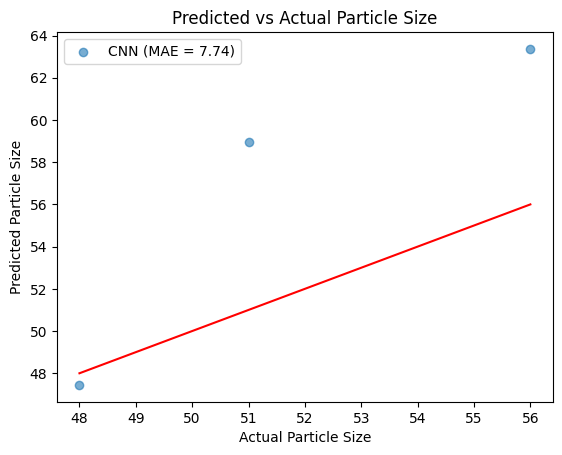

In [7]:
average_mae = np.mean(cv_results)
print(f"Average MAE from cross-validation: {average_mae}")

# Performance evaluation for the final model on test data
cnn_predictions = cnn_model.predict(test_x)
cnn_mae = np.mean(np.abs(test_y - cnn_predictions))
print(f"CNN MAE: {cnn_mae}")

# Plot predicted vs actual values for CNN
plt.scatter(test_y, cnn_predictions, label=f'CNN (MAE = {cnn_mae:.2f})', alpha=0.6)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red')
plt.xlabel('Actual Particle Size')
plt.ylabel('Predicted Particle Size')
plt.title('Predicted vs Actual Particle Size')
plt.legend()
plt.show()